In this notebook I create the tables I'm gonna use for the recommender systems and compute some statistics in order to better understand the dataset I'm working with.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


I start importing the users table, removing the columns I don't need and banned users.

In [4]:
users = pd.read_csv("database/telegrambot_user.csv")
users.drop(
    columns=["reputation", "warn_count", "permissions_level", "last_seen"], inplace=True
)
users = users[users.banned == "f"]
users.drop(columns="banned", inplace=True)
users.rename({"id": "user_id"}, inplace=True, axis=1)
users.to_pickle("users.pkl")


Then I do the same for the groups table, removing the groups I don't want to recommend.

In [5]:
groups = pd.read_csv("database/telegrambot_group.csv")
groups.drop(
    columns=[
        "profile_picture",
        "invite_link",
        "owner_id",
        "bot_id",
        "welcome_model",
        "ignore_admin_tagging",
        "description",
    ],
    inplace=True,
)
groups.rename({"id": "group_id"}, inplace=True, axis=1)
to_delete = [
    -1001394272076,
    -1001586960044,
    -1001581680126,
    -1001317570364,
    -1001597995872,
    -1001399541270,
    -1001374431808,
    -1001429342185,
    -1001314188573,
    -1001161201627,
]
groups = groups[~(groups.group_id.isin(to_delete))]
groups.to_pickle("groups.pickle")


Group membership is the table that links each user with each group in which he has been (including the groups he has left). I remove userbots from it.

In [6]:
group_membership = pd.read_csv("database/telegrambot_groupmembership.csv")
df_membership = users.merge(group_membership, on=["user_id"]).merge(
    groups, on=["group_id"]
)
df_membership = df_membership[df_membership.status != "kicked"]
df_membership = df_membership[df_membership.username != "studentiunimibot"]
df_membership = df_membership[df_membership.username != "areyouseeingthistoo"]
pd.to_pickle(df_membership, "df_membership.pkl")
df_membership[df_membership.username == "aleceres"].head()


,user_id,first_name,last_name,username,id,group_id,last_seen,messages_count,status,title
190,350313104,Alessia,NaN,aleceres,3112,-1001568744489,2021-09-13 21:34:00.243643+00,3,member,Bioinformatics for computational genomics
1802,350313104,Alessia,NaN,aleceres,14052,-1001461601993,2021-10-13 18:17:29.48649+00,2,member,Tirocini e tesi - StudentiUniMi
2018,350313104,Alessia,NaN,aleceres,16395,-1001405226631,2021-11-15 13:24:07.170593+00,3,member,Videogame Design and Programming
2203,350313104,Alessia,NaN,aleceres,17326,-1001342690802,2022-04-02 17:21:46.070376+00,7,administrator,Bioinformatics - Informatica magistrale
3196,350313104,Alessia,NaN,aleceres,16341,-1001357462160,2022-04-02 17:21:45.456724+00,9,administrator,Fisica - Informatica


I compute some statistics in order to better understand the dataset. Here is the description of the number of groups in which each user is: on average, a user is in around 3 groups with a standard deviation of 5, but with the presence of outliers (users in around 100 groups).

In [67]:
groups_per_user = (
    df_membership[df_membership.status != "left"]
    .groupby(by=["user_id", "username"])
    .count()["group_id"]
    .sort_values(ascending=False)
)
groups_per_user.describe()


count    2948.000000
mean        3.912822
std         4.774117
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       119.000000
Name: group_id, dtype: float64

On the x axis, I have the number of groups; on the y axis, the percentage of users that are in that number of groups. Also here we can see that most of the users tend to be in a range of 1 to 15 groups.

Text(0, 0.5, 'percentage of users')

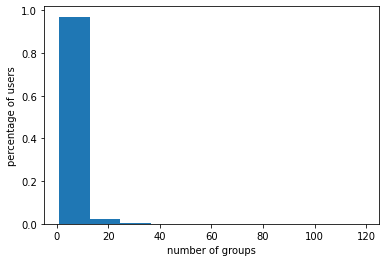

In [68]:
plt.hist(groups_per_user, weights=np.ones(len(groups_per_user)) / len(groups_per_user))
plt.xlabel("number of groups")
plt.ylabel("percentage of users")


I compute similar statistics for the number of users per group. Here we can see the 5 most popular groups.

In [14]:
users_per_group = (
    df_membership[df_membership.status != "left"]
    .groupby(by=["group_id", "title"])
    .count()["user_id"]
    .sort_values(ascending=False)[:20]
)
users_per_group[:5]


group_id        title                                                                            
-1001456212600  Chat | Studenti UniMi                                                                1002
-1001260565113  Compravendita libri e appunti - StudentiUniMi                                         713
-1001157628331  Programmazione 1 - Informatica, Informatica Musicale, Informatica per la Com Dig.     435
-1001461601993  Tirocini e tesi - StudentiUniMi                                                       430
-1001348138483  Annunci di lavoro - StudentiUniMi                                                     338
Name: user_id, dtype: int64

Here we can visualize the statistics related to the number of users per group: the distribution is less uniform than the previous one.

Text(0, 0.5, 'percentage of groups')

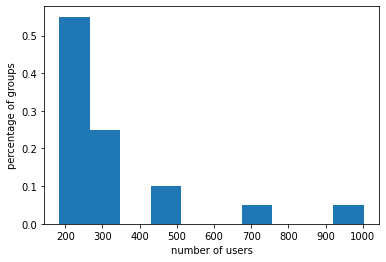

In [15]:
plt.hist(users_per_group, weights=np.ones(len(users_per_group)) / len(users_per_group))
plt.xlabel("number of users")
plt.ylabel("percentage of groups")


I also create a trainset and a testset, which I will use to evaluate the recommender systems later.

In [7]:
df_membership.sort_values(by = ['last_seen'], inplace = True)
testset = df_membership[(df_membership.messages_count >= 3) & (df_membership.messages_count <800)]
testset = testset.drop_duplicates(subset = ['user_id'], keep = 'last')

train_set = df_membership.drop(list(testset.index))
testset = testset[testset.user_id.isin(train_set.user_id)]

train_set.to_pickle("trainset.pkl")
testset.to_pickle("testset.pkl")